In [ ]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import io
import torch.nn as nn
import os
import pandas as pd
import cv2
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from torchvision import transforms
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
import gc

# prepare data

## hàm load_video

In [ ]:
def load_video(path, max_frame=100, size=(480,480)):
    capture = cv2.VideoCapture(path)
    all_frames = []
    while True:
        ret, frame = capture.read()
        if len(all_frames) == max_frame:
            break
        if not ret:
            break
        frame = get_center_square(frame)
        frame = cv2.resize(frame,size)
        frame = frame[:, :, [2,1,0]] # ảnh đọc ra bởi cv2 ở dạng BGR, chuyển về RGB
        frame = torch.tensor(frame)
        frame = frame.permute(2,0,1) # chuyển về channel, height, width
        all_frames.append(frame)
    capture.release()
    return torch.stack(all_frames, dim=0) # dim = (100, 3, size[0], size[1])


"""Get center square of frame"""
def get_center_square(frame):
    y, x = frame.shape[0:2]
    min_lenght = min(x,y)
    start_x = (x//2) - min_lenght//2
    start_y = (y//2) - min_lenght//2
    frame = frame[start_y : start_y + min_lenght, start_x : start_x + min_lenght]
    return frame

In [ ]:
folder_path_train = "./video_data/train/"
folder_path_test = "./video_data/test/"

train_df = pd.read_csv("./video_data/train.csv")
test_df = pd.read_csv("./video_data/test.csv")

## tạo dataframe

In [ ]:
def create_dataframe_metadata(df, start, end, label_encoder=None, encode_label=None):
    df_punch = df[df['tag'] == 'Punch']
    df_playCello = df[df['tag'] == 'PlayingCello']
    df_CricketShot = df[df['tag'] == 'CricketShot']
    df_ShavingBeard = df[df['tag'] == 'ShavingBeard']
    df_TennisSwing = df[df['tag'] == 'TennisSwing']
    new_df = pd.concat([df_punch[start:end], df_playCello[start:end], df_CricketShot[start:end], df_ShavingBeard[start:end], df_TennisSwing[start:end]], ignore_index=True)
    new_df['origin_tag'] = new_df['tag']
    if label_encoder is not None:
        new_df['tag'] = label_encoder.fit_transform(new_df['tag'])
    else:
        new_df['tag'] = new_df['tag'].map(encode_label)
    return new_df

In [ ]:
label_encoder = LabelEncoder()

In [ ]:
df_train = create_dataframe_metadata(train_df, 0, 90, label_encoder=label_encoder)
df_train

,video_name,tag,origin_tag
0,v_Punch_g08_c01.avi,2,Punch
1,v_Punch_g08_c02.avi,2,Punch
2,v_Punch_g08_c03.avi,2,Punch
3,v_Punch_g08_c04.avi,2,Punch
4,v_Punch_g08_c05.avi,2,Punch
...,...,...,...
445,v_TennisSwing_g20_c05.avi,4,TennisSwing
446,v_TennisSwing_g20_c06.avi,4,TennisSwing
447,v_TennisSwing_g21_c01.avi,4,TennisSwing
448,v_TennisSwing_g21_c02.avi,4,TennisSwing


In [ ]:
decode_label = dict()
for index, row in df_train.iterrows():
    decode_label.update({row['tag']: row['origin_tag']})
encode_label = {v:k for k,v in decode_label.items()}

In [ ]:
df_val = create_dataframe_metadata(train_df, 90, 110, encode_label=encode_label)
df_test = create_dataframe_metadata(test_df, 0, 50, encode_label=encode_label)
df_test

,video_name,tag,origin_tag
0,v_Punch_g01_c01.avi,2,Punch
1,v_Punch_g01_c02.avi,2,Punch
2,v_Punch_g01_c03.avi,2,Punch
3,v_Punch_g01_c04.avi,2,Punch
4,v_Punch_g01_c05.avi,2,Punch
...,...,...,...
219,v_TennisSwing_g07_c03.avi,4,TennisSwing
220,v_TennisSwing_g07_c04.avi,4,TennisSwing
221,v_TennisSwing_g07_c05.avi,4,TennisSwing
222,v_TennisSwing_g07_c06.avi,4,TennisSwing


## tăng cường data

In [ ]:

def augmentation_picture(frame):
    transform_a_frame = transforms.Compose([
        transforms.GaussianBlur(kernel_size=11, sigma=1), # làm mờ ảnh nhẹ với vùng ảnh là 11x11
        transforms.RandomErasing(scale=(0.01, 0.1), ratio=(1, 1)) # scale là phạm vi tỷ lệ (min, max) cho vùng xóa so với ảnh ban đầu, ratio là tỉ lệ chiều rộng và cao
    ])
    result = transform_a_frame(frame)
    return result

def augmentation_video(frames):
    new_frames = []
    for frame in frames:
        new_frame = augmentation_picture(frame)
        new_frames.append(new_frame)
    return torch.stack(new_frames,dim=0)

## dataset object

In [ ]:
class VideoDataset(Dataset):
    def __init__(self, video_paths, img_size=(120,120), all_labels=[], is_train=True):
        self.video_paths = video_paths
        self.img_size = img_size
        self.all_labels = all_labels
        self.new_labels = []
        self.is_train = is_train
        self.data = self.load_data()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.new_labels[index]

    def load_data(self):
        data = []

        for index, path in tqdm(enumerate(self.video_paths)):
            frames = load_video(path, size=self.img_size)
            self.new_labels.append(self.all_labels[index])
            data.append(frames)

            if self.is_train:
                new_frames = augmentation_video(frames)
                data.append(new_frames)
                self.new_labels.append(self.all_labels[index])
        return pad_sequence(data, batch_first=True, padding_value=0)

In [ ]:
all_label_train = list(df_train['tag'])
all_label_val = list(df_val['tag'])

In [ ]:
train_paths = [os.path.join(folder_path_train, i) for i in df_train['video_name']]
test_paths = [os.path.join(folder_path_test, i) for i in df_test['video_name']]
val_paths = [os.path.join(folder_path_train, i) for i in df_val['video_name']]

## Kiểm tra load_video

In [ ]:
load_video(train_paths[10])[0].shape # channel, height, width

torch.Size([3, 480, 480])

100


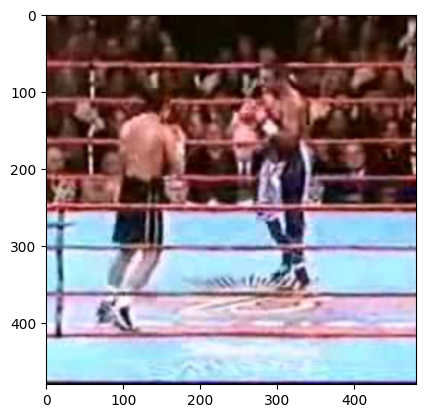

In [ ]:
vid0_frame = load_video(val_paths[10])
print(len(vid0_frame))
img_plot_test = vid0_frame[0].permute(1,2,0).numpy() # chuyển về height, width, channel để plot ảnh (224,224,3)
plt.imshow(img_plot_test)

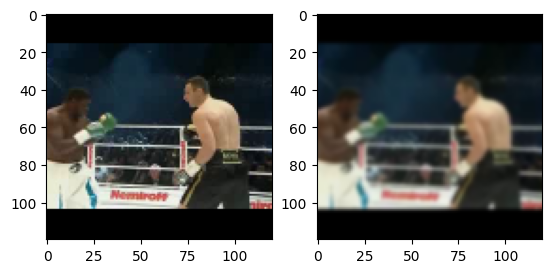

In [ ]:
test_augment_path = train_paths[20]
frames_before = load_video(test_augment_path, size=(120,120))
frames_after = augmentation_video(frames_before)

img_after_augment = frames_after[0].permute(1,2,0).numpy()
img_before_augment = frames_before[0].permute(1,2,0).numpy()
fig_aug, ax_aug = plt.subplots(1,2)
ax_aug[0].imshow(img_before_augment)
ax_aug[1].imshow(img_after_augment)

## tạo dataset

In [ ]:
train_dataset = VideoDataset(train_paths, all_labels= all_label_train)
val_dataset = VideoDataset(val_paths, all_labels= all_label_val)
test_dataset = VideoDataset(test_paths, all_labels= list(df_test['tag']), is_train=False)

450it [00:46,  9.77it/s]
100it [00:10,  9.47it/s]
224it [00:08, 25.30it/s]


Punch


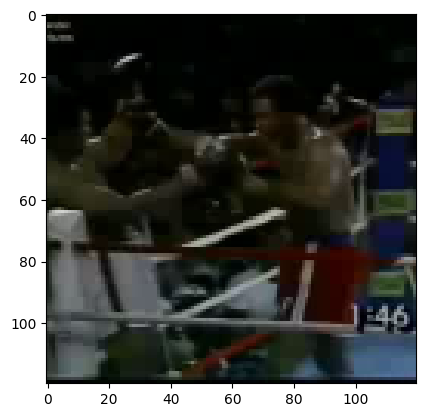

In [ ]:
frames, label = train_dataset.__getitem__(100)
print(decode_label[label])
plt.imshow(frames[0].permute(1,2,0).numpy())

## lưu và load dataset

In [ ]:
import pickle

def save_dataset(dataset, path):
    with open(path, 'wb') as f:
        pickle.dump(dataset, f)

def load_dataset(path):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    return data

### lưu dataset

In [ ]:
save_dataset(train_dataset, "./dataset/train_dataset.pickle")
save_dataset(val_dataset, "./dataset/val_dataset.pickle")
save_dataset(test_dataset, "./dataset/test_dataset.pickle")

### load dataset tạo dataloader

In [ ]:
train_dataset = load_dataset("./dataset/train_dataset.pickle")
val_dataset = load_dataset("./dataset/val_dataset.pickle")
test_dataset = load_dataset("./dataset/test_dataset.pickle")

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Mô hình

## CNN pretrainned

In [ ]:
CNNPretrained = torchvision.models.resnet50(pretrained=True)

c:\Users\TANPHAT\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\TANPHAT\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
list(CNNPretrained.children())

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): Bottleneck(
     (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (downsample): Sequential(
       (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum

In [ ]:
CNNPretrained = torch.nn.Sequential(*list(CNNPretrained.children())[:8])

## kiểm tra CNN pretrainned

In [ ]:
sample_frames, sample_label = next(iter(val_dataloader))
print(decode_label[int(sample_label[0])])
sample_frames.shape

TennisSwing


torch.Size([16, 100, 3, 120, 120])

In [ ]:
output_test = CNNPretrained(sample_frames[:,1].float())
output_test.shape

torch.Size([16, 2048, 4, 4])

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## mô hình tổng

In [ ]:
class LSTM(nn.Module):
    def __init__(self, CNNPretrained, hidden_size, num_classes, batch_size):
        super(LSTM, self).__init__()
        self.CNNPretrained = CNNPretrained
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.batch_size = batch_size

        self.lstm = nn.LSTM(input_size=(2048*4*4), hidden_size=hidden_size, num_layers=4, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        input = list()
        for index in range(x.size(1)):
            hidden = torch.zeros((self.batch_size, self.hidden_size))
            frame = x[:, index]

            frame = frame.float()
            with torch.no_grad():
                _x = self.CNNPretrained(frame)
                _x = _x.view(_x.size(0), 2048*4*4)
            input.append(_x)
        input = torch.stack(input, dim=1)

        out1, hidden1 = self.lstm(input)
        res = self.fc1(hidden1[0])
        x = self.fc2(res[0])

        return x

In [ ]:
model = LSTM(CNNPretrained, 512, 5, 16)
model = model.to(device)

# early stop

In [ ]:
# Thêm patience và delta vào EarlyStopping
class EarlyStopping:
    def __init__(self, path_to_save, delta = 0.01, patience = 3, restore_best_weights=True):
        '''
        delta là tham số kiểm soát độ dao động của loss, loss ở các epoch đầu được phép dao dộng lớn hơn loss ở các epoch về sau
        patience là số lượng epoch mà loss không giảm thì sẽ dừng train
        restore_best_weights là lựa chọn có restore lại weight tốt nhất hay không
        '''
        self.best_val_loss_average = np.inf
        self.path_to_save = path_to_save
        self.early_stop = False
        self.delta = delta
        self.patience = patience
        self.counter = 0
        self.restore_best_weights = restore_best_weights
        self.best_weights = None

    def __call__(self, current_average_loss_val, model):
        if current_average_loss_val < self.best_val_loss_average:
            print(f"loss validation average decrease from {self.best_val_loss_average} to {current_average_loss_val}, Saving checkpoint...")
            self.best_val_loss_average = current_average_loss_val
            self.counter = 0
            self.best_weights = model.state_dict()
            torch.save(model.state_dict(), self.path_to_save)
        elif current_average_loss_val < self.best_val_loss_average + self.delta*self.best_val_loss_average:
            print(f"loss validation average slightly increased from {self.best_val_loss_average} to {current_average_loss_val}, No save! ")
            self.counter += 1
        else:
            self.counter += 1
            print(f"No improvement. Early stopping counter: {self.counter}/{self.patience}")

        # Nếu counter >= patience thì dừng train
        if self.counter >= self.patience:
            print("Early stopping")
            self.early_stop = True
            if self.restore_best_weights and self.best_weights is not None:
                model.load_state_dict(self.best_weights)
                print("Restore best weights")


# trainner

In [ ]:
# Thêm path_to_save ở hàm train để lưu checkpoint
class Trainer:
    def __init__(self, dataloader_train, dataloader_val, model, optimizer, criterion, epochs=1):
        self.dataloader_train = dataloader_train
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.epochs = epochs
        self.dataloader_val = dataloader_val
        self.history_average_train_loss = []
        self.history_average_train_acc = []
        self.history_average_val_loss = []
        self.history_average_val_acc = []
        self.history_train_acc = []
        self.epoch_after_early_stop = 1
        self.early_stop_epoch = 0
    def val(self, model_val, device):
        torch.cuda.empty_cache()
        pbar_val = tqdm(self.dataloader_val)
        total_val = 0
        total_correct_val = 0
        all_loss_vall_current = []
        all_acc_vall_current = []
        for a, b in pbar_val:
            a = a.to(device)
            b = b.to(device)
            out = model_val(a)
            out = out.to(device)
            criterion_val = self.criterion
            loss_val = criterion_val(out, b)
            all_loss_vall_current.append(loss_val.cpu().detach().numpy())
            total_correct_val += (torch.argmax(out, dim=1) == b).sum().item()
            total_val += b.size(0)
            acc_val = total_correct_val/total_val
            all_acc_vall_current.append(acc_val)
            pbar_val.set_description(f'Acc_val: {acc_val} loss_val {loss_val}')
        loss_val_average = np.average(all_loss_vall_current)
        self.history_average_val_loss.append(loss_val_average)
        self.history_average_val_acc.append(np.average(all_acc_vall_current))
        return loss_val_average

    def train(self, path_to_save):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = self.model
        model.to(device)
        optimizer = self.optimizer
        criterion = self.criterion
        early_stopping = EarlyStopping( path_to_save, delta=0.1)
        index_after_early_stop = 0
        for epoch in range(self.epochs):
            model.train()
            current_loss_train = []
            current_acc_train = []
            pbar = tqdm(self.dataloader_train)
            total = 0
            total_correct = 0
            print(optimizer.param_groups[0]['lr'])
            for X, y in pbar:
                torch.cuda.empty_cache()
                optimizer.zero_grad()
                X = X.to(device)
                y = y.to(device)
                yh = model(X)
                yh = yh.to(device)
                total_correct += (torch.argmax(yh, dim=1) == y).sum().item()
                total += y.size(0)
                acc = total_correct/total
                loss = criterion(yh, y)
                '''
                Với criterion là CrossEntropyLoss thì thứ tự là output trc rồi đến target
                    vì hàm này yêu cầu chiều của output là (batch_size x class) còn chiều của target là (batch_size)
                '''
                current_loss_train.append(loss.item())
                current_acc_train.append(acc)
                self.history_train_acc.append(acc)
                loss.backward()
                optimizer.step()
                pbar.set_description(f'Epoch: {epoch} Loss: {loss.item()}, Acc: {acc}')
            self.history_average_train_loss.append(np.average(current_loss_train))
            self.history_average_train_acc.append(np.average(current_acc_train))
            current_average_loss_val = self.val(model.eval(), device)
            print(f"Average loss val: {current_average_loss_val}")
            if early_stopping.early_stop:
                index_after_early_stop += 1
                print(f"epoch {index_after_early_stop} after early stop")
                if index_after_early_stop == self.epoch_after_early_stop:
                    break
                continue
            early_stopping.delta = 1 * (1/(epoch+1)) # điều chỉnh tham số delta theo epoch
            early_stopping(current_average_loss_val, model)
            if early_stopping.early_stop:
                print("\n early stop")
                self.early_stop_epoch = epoch


# new trainner

In [ ]:
# scheduler ReduceLROnPlateau
# Thêm path_to_save ở hàm train để lưu checkpoint, áp dụng schedule để giảm learning rate
class NewTrainer:
    def __init__(self, dataloader_train, dataloader_val, model, optimizer, criterion, epochs=1, scheduler=None):
        self.dataloader_train = dataloader_train
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.epochs = epochs
        self.dataloader_val = dataloader_val
        self.history_average_train_loss = []
        self.history_average_train_acc = []
        self.history_average_val_loss = []
        self.history_average_val_acc = []
        self.history_train_acc = []
        self.epoch_after_early_stop = 1
        self.early_stop_epoch = 0

        # Thêm scheduler
        self.scheduler = scheduler
    def val(self, model_val, device):
        torch.cuda.empty_cache()
        pbar_val = tqdm(self.dataloader_val)
        total_val = 0
        total_correct_val = 0
        all_loss_vall_current = []
        all_acc_vall_current = []
        for a, b in pbar_val:
            a = a.to(device)
            b = b.to(device)
            out = model_val(a)
            out = out.to(device)
            criterion_val = self.criterion
            loss_val = criterion_val(out, b)
            all_loss_vall_current.append(loss_val.cpu().detach().numpy())
            total_correct_val += (torch.argmax(out, dim=1) == b).sum().item()
            total_val += b.size(0)
            acc_val = total_correct_val/total_val
            all_acc_vall_current.append(acc_val)
            pbar_val.set_description(f'Acc_val: {acc_val} loss_val {loss_val}')
        loss_val_average = np.average(all_loss_vall_current)
        self.history_average_val_loss.append(loss_val_average)
        self.history_average_val_acc.append(np.average(all_acc_vall_current))
        return loss_val_average

    def train(self, path_to_save):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = self.model
        model.to(device)
        optimizer = self.optimizer
        criterion = self.criterion
        early_stopping = EarlyStopping( path_to_save, delta=0.1)
        index_after_early_stop = 0
        for epoch in range(self.epochs):
            model.train()
            current_loss_train = []
            current_acc_train = []
            pbar = tqdm(self.dataloader_train)
            total = 0
            total_correct = 0
            print(optimizer.param_groups[0]['lr'])
            for X, y in pbar:
                torch.cuda.empty_cache()
                optimizer.zero_grad()
                X = X.to(device)
                y = y.to(device)
                yh = model(X)
                yh = yh.to(device)
                total_correct += (torch.argmax(yh, dim=1) == y).sum().item()
                total += y.size(0)
                acc = total_correct/total
                loss = criterion(yh, y)
                '''
                Với criterion là CrossEntropyLoss thì thứ tự là output trc rồi đến target
                    vì hàm này yêu cầu chiều của output là (batch_size x class) còn chiều của target là (batch_size)
                '''
                current_loss_train.append(loss.item())
                current_acc_train.append(acc)
                self.history_train_acc.append(acc)
                loss.backward()
                optimizer.step()
                pbar.set_description(f'Epoch: {epoch} Loss: {loss.item()}, Acc: {acc}')
            self.history_average_train_loss.append(np.average(current_loss_train))
            self.history_average_train_acc.append(np.average(current_acc_train))
            current_average_loss_val = self.val(model.eval(), device)

            # Thêm scheduler.step
            if self.scheduler:
                if isinstance(self.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    self.scheduler.step(current_average_loss_val)  # Với ReduceLROnPlateau
                    print(f"Learning rate hiện tại: {optimizer.param_groups[0]['lr']}")

            print(f"current_average_loss_val: {current_average_loss_val}")

            if early_stopping.early_stop:
                index_after_early_stop += 1
                print(f"epoch {index_after_early_stop} after early stop")
                if index_after_early_stop == self.epoch_after_early_stop:
                    break
                continue
            early_stopping.delta = 1 * (1/(epoch+1)) # điều chỉnh tham số delta theo epoch
            early_stopping(current_average_loss_val, model)
            if early_stopping.early_stop:
                print("\n early stop")
                self.early_stop_epoch = epoch


# tester

In [ ]:
class Tester:
    def __init__(self, model, dataloader_test):
        self.dataloader_test = dataloader_test
        self.model = model
    def test(self):
        torch.cuda.empty_cache()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model_test = self.model
        model_test.to(device)
        pbar_test = tqdm(self.dataloader_test)
        total_test = 0
        total_correct_test = 0
        for a, b in pbar_test:
            a = a.to(device)
            b = b.to(device)
            out = model_test(a)
            total_correct_test += (torch.argmax(out, dim=1) == b).sum().item()
            total_test += b.size(0)
            acc_test = total_correct_test/total_test
            pbar_test.set_description(f'Acc_test: {acc_test}')

# trainner thường

In [ ]:
trainer = Trainer(train_dataloader, val_dataloader, model, torch.optim.AdamW(model.parameters(), lr=0.0001), nn.CrossEntropyLoss(), epochs=100)

## train

In [ ]:
torch.cuda.empty_cache()
trainer.train("model50(16-0.0001-num5)_checkpoint.pt")

  0%|          | 0/57 [00:00<?, ?it/s]

0.0001


Epoch: 0 Loss: 0.41740506887435913, Acc: 0.7977777777777778: 100%|██████████| 57/57 [01:46<00:00,  1.86s/it]
Acc_val: 0.7 loss_val 0.6965250968933105: 100%|██████████| 13/13 [00:21<00:00,  1.62s/it]               


Average loss val: 0.8678351044654846
loss validation average decrease from inf to 0.8678351044654846, Saving checkpoint...


  0%|          | 0/57 [00:00<?, ?it/s]

0.0001


Epoch: 1 Loss: 0.29693368077278137, Acc: 0.9466666666666667: 100%|██████████| 57/57 [01:46<00:00,  1.87s/it]
Acc_val: 0.78 loss_val 0.7122770547866821: 100%|██████████| 13/13 [00:21<00:00,  1.62s/it]               


Average loss val: 0.5613721013069153
loss validation average decrease from 0.8678351044654846 to 0.5613721013069153, Saving checkpoint...


  0%|          | 0/57 [00:00<?, ?it/s]

0.0001


Epoch: 2 Loss: 0.19368116557598114, Acc: 0.9733333333333334: 100%|██████████| 57/57 [01:46<00:00,  1.86s/it] 
Acc_val: 0.74 loss_val 1.1172086000442505: 100%|██████████| 13/13 [00:21<00:00,  1.62s/it]              


Average loss val: 0.7059903740882874
loss validation average slightly increased from 0.5613721013069153 to 0.7059903740882874, No save! 


  0%|          | 0/57 [00:00<?, ?it/s]

0.0001


Epoch: 3 Loss: 0.25109779834747314, Acc: 0.9877777777777778: 100%|██████████| 57/57 [01:46<00:00,  1.86s/it] 
Acc_val: 0.81 loss_val 0.19246572256088257: 100%|██████████| 13/13 [00:20<00:00,  1.59s/it]             


Average loss val: 0.49913153052330017
loss validation average decrease from 0.5613721013069153 to 0.49913153052330017, Saving checkpoint...


  0%|          | 0/57 [00:00<?, ?it/s]

0.0001


Epoch: 4 Loss: 0.07069382816553116, Acc: 0.9944444444444445: 100%|██████████| 57/57 [01:47<00:00,  1.88s/it] 
Acc_val: 0.745 loss_val 0.5714941024780273: 100%|██████████| 13/13 [00:20<00:00,  1.61s/it]             


Average loss val: 0.5890700817108154
loss validation average slightly increased from 0.49913153052330017 to 0.5890700817108154, No save! 


  0%|          | 0/57 [00:00<?, ?it/s]

0.0001


Epoch: 5 Loss: 0.07371443510055542, Acc: 0.9944444444444445: 100%|██████████| 57/57 [01:47<00:00,  1.88s/it] 
Acc_val: 0.85 loss_val 0.3498179316520691: 100%|██████████| 13/13 [00:20<00:00,  1.61s/it]               


Average loss val: 0.3837151825428009
loss validation average decrease from 0.49913153052330017 to 0.3837151825428009, Saving checkpoint...


  0%|          | 0/57 [00:00<?, ?it/s]

0.0001


Epoch: 6 Loss: 0.024680156260728836, Acc: 0.9988888888888889: 100%|██████████| 57/57 [01:45<00:00,  1.86s/it] 
Acc_val: 0.795 loss_val 0.9292019605636597: 100%|██████████| 13/13 [00:20<00:00,  1.61s/it]              


Average loss val: 0.4618607759475708
No improvement. Early stopping counter: 1/3


  0%|          | 0/57 [00:00<?, ?it/s]

0.0001


Acc_val: 0.685 loss_val 1.106900930404663: 100%|██████████| 13/13 [00:20<00:00,  1.61s/it]              


Average loss val: 0.7557270526885986
No improvement. Early stopping counter: 2/3


  0%|          | 0/57 [00:00<?, ?it/s]

0.0001


Acc_val: 0.815 loss_val 0.3963348865509033: 100%|██████████| 13/13 [00:21<00:00,  1.62s/it]              


Average loss val: 0.41299936175346375
loss validation average slightly increased from 0.3837151825428009 to 0.41299936175346375, No save! 
Early stopping
Restore best weights

 early stop


  0%|          | 0/57 [00:00<?, ?it/s]

0.0001


Acc_val: 0.685 loss_val 1.4288394451141357: 100%|██████████| 13/13 [00:20<00:00,  1.61s/it]             

Average loss val: 1.0712562799453735
epoch 1 after early stop


In [ ]:
trainer.history_average_val_loss

[0.8678351,
 0.5613721,
 0.7059904,
 0.49913153,
 0.5890701,
 0.38371518,
 0.46186078,
 0.75572705,
 0.41299936,
 1.0712563]

In [ ]:
trainer.history_average_train_loss

[0.8241692721320871,
 0.25616944411344694,
 0.13745546157945665,
 0.08608051020194564,
 0.05389307771008788,
 0.03657214948090545,
 0.022161613994588453,
 0.015242256444731825,
 0.01126886470030928,
 0.008431053497795864]

In [ ]:
trainer.history_average_val_acc

[0.731959706959707,
 0.7752443043068044,
 0.7442512001887002,
 0.7942788461538461,
 0.7198892080142081,
 0.8453647047397048,
 0.7942910214785215,
 0.6725790182040181,
 0.8115016580641581,
 0.686109584859585]

In [ ]:
trainer.history_average_train_acc

[0.6782907512023337,
 0.9482735306318806,
 0.9657102929059832,
 0.9872418599229976,
 0.9945177434883887,
 0.9960040553782806,
 0.9989211749695195,
 1.0,
 1.0,
 1.0]

In [ ]:
model_save = LSTM(CNNPretrained, 512, 5, 16)
model_save.load_state_dict(torch.load("model50(16-0.0001-num5)_checkpoint.pt"))

C:\Users\TANPHAT\AppData\Local\Temp\ipykernel_14892\315182704.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_save.load_state_dict(torch.load("model50(16-0.0001-nu

<All keys matched successfully>

## Kết quả

In [ ]:
test = Tester(model_save, test_dataloader)
test.test()

Acc_test: 0.7946428571428571: 100%|██████████| 14/14 [00:23<00:00,  1.68s/it]


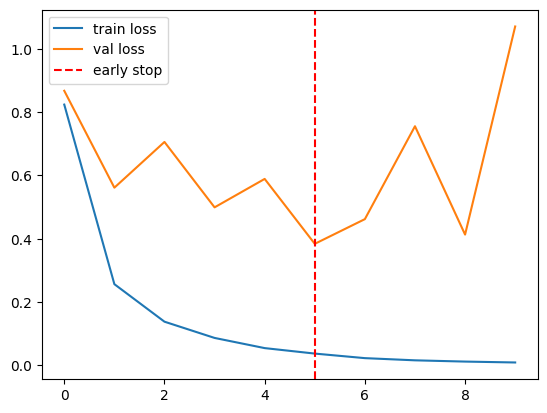

In [ ]:
# Plot training loss và validation loss, early stop ở epoch nào
plt.plot(trainer.history_average_train_loss, label='train loss')
plt.plot(trainer.history_average_val_loss, label='val loss')
plt.axvline(trainer.early_stop_epoch - 3, color='r', linestyle='--', label='early stop')
plt.legend()
plt.show()

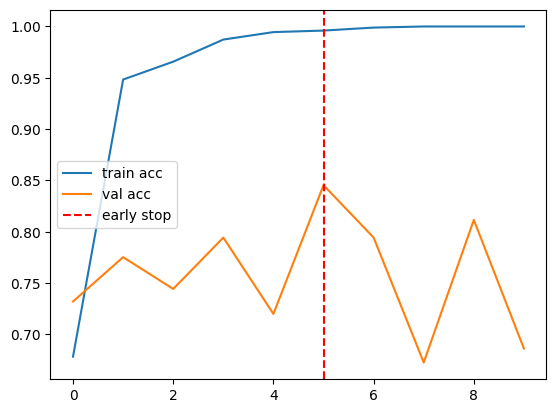

In [ ]:
# Plot cho accuracy
plt.plot(trainer.history_average_train_acc, label='train acc')
plt.plot(trainer.history_average_val_acc, label='val acc')
plt.axvline(trainer.early_stop_epoch-3, color='r', linestyle='--', label='early stop')
plt.legend()
plt.show()

# NewTrainer với scheduler

In [ ]:
# scheduler ReduceLROnPlateau
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, verbose=True)
'''
mode=min: giảm learning rate nếu giá trị của metric không giảm
factor: hệ số giảm của learning rate lr_new = factor*lr_old
patience: số epoch mà metric không giảm thì sẽ giảm learning rate
'''

In [ ]:
trainer1 = NewTrainer(train_dataloader, val_dataloader, model, optimizer, nn.CrossEntropyLoss(), epochs=100, scheduler=scheduler)

## train

In [ ]:
torch.cuda.empty_cache()
trainer1.train("model50(16-ReduceLR-num4)_checkpoint.pt")

  0%|          | 0/57 [00:00<?, ?it/s]

0.0001


Epoch: 0 Loss: 0.6573061347007751, Acc: 0.7866666666666666: 100%|██████████| 57/57 [01:45<00:00,  1.86s/it] 
Acc_val: 0.565 loss_val 1.2262868881225586: 100%|██████████| 13/13 [00:21<00:00,  1.62s/it]             


Learning rate hiện tại: 0.0001
current_average_loss_val: 1.0524952411651611
loss validation average decrease from inf to 1.0524952411651611, Saving checkpoint...


  0%|          | 0/57 [00:00<?, ?it/s]

0.0001


Epoch: 1 Loss: 0.25846028327941895, Acc: 0.9533333333333334: 100%|██████████| 57/57 [01:45<00:00,  1.86s/it]
Acc_val: 0.825 loss_val 0.6786034107208252: 100%|██████████| 13/13 [00:20<00:00,  1.60s/it]             


Learning rate hiện tại: 0.0001
current_average_loss_val: 0.5425204634666443
loss validation average decrease from 1.0524952411651611 to 0.5425204634666443, Saving checkpoint...


  0%|          | 0/57 [00:00<?, ?it/s]

0.0001


Epoch: 2 Loss: 0.1919538825750351, Acc: 0.9822222222222222: 100%|██████████| 57/57 [01:43<00:00,  1.81s/it]  
Acc_val: 0.76 loss_val 0.4587109088897705: 100%|██████████| 13/13 [00:20<00:00,  1.57s/it]              


Learning rate hiện tại: 0.0001
current_average_loss_val: 0.5181667804718018
loss validation average decrease from 0.5425204634666443 to 0.5181667804718018, Saving checkpoint...


  0%|          | 0/57 [00:00<?, ?it/s]

0.0001


Epoch: 3 Loss: 0.7946594953536987, Acc: 0.9877777777777778: 100%|██████████| 57/57 [01:43<00:00,  1.81s/it]  
Acc_val: 0.74 loss_val 0.6887576580047607: 100%|██████████| 13/13 [00:20<00:00,  1.58s/it]               


Learning rate hiện tại: 0.0001
current_average_loss_val: 0.6265573501586914
loss validation average slightly increased from 0.5181667804718018 to 0.6265573501586914, No save! 


  0%|          | 0/57 [00:00<?, ?it/s]

0.0001


Epoch: 4 Loss: 0.07177945226430893, Acc: 0.9911111111111112: 100%|██████████| 57/57 [01:43<00:00,  1.81s/it] 
Acc_val: 0.65 loss_val 0.41270458698272705: 100%|██████████| 13/13 [00:20<00:00,  1.57s/it]             


Learning rate hiện tại: 1e-05
current_average_loss_val: 0.7306439280509949
loss validation decrease from 0.4587109088897705 to 0.41270458698272705, Saving checkpoint...


  0%|          | 0/57 [00:00<?, ?it/s]

1e-05


Epoch: 5 Loss: 0.11660092324018478, Acc: 0.9944444444444445: 100%|██████████| 57/57 [01:43<00:00,  1.81s/it] 
Acc_val: 0.86 loss_val 0.1829708367586136: 100%|██████████| 13/13 [00:20<00:00,  1.57s/it]               


Learning rate hiện tại: 1e-05
current_average_loss_val: 0.3614960014820099
loss validation average decrease from 0.5181667804718018 to 0.3614960014820099, Saving checkpoint...


  0%|          | 0/57 [00:00<?, ?it/s]

1e-05


Epoch: 6 Loss: 0.01556699350476265, Acc: 0.9955555555555555: 100%|██████████| 57/57 [01:42<00:00,  1.81s/it] 
Acc_val: 0.73 loss_val 0.44954878091812134: 100%|██████████| 13/13 [00:20<00:00,  1.57s/it]              


Learning rate hiện tại: 1e-05
current_average_loss_val: 0.650806725025177
No improvement. Early stopping counter: 1/3


  0%|          | 0/57 [00:00<?, ?it/s]

1e-05


Epoch: 7 Loss: 0.030844157561659813, Acc: 0.9955555555555555: 100%|██████████| 57/57 [01:42<00:00,  1.81s/it]
Acc_val: 0.76 loss_val 0.4085153341293335: 100%|██████████| 13/13 [00:20<00:00,  1.57s/it]              


Learning rate hiện tại: 1.0000000000000002e-06
current_average_loss_val: 0.5916898250579834
No improvement. Early stopping counter: 2/3


  0%|          | 0/57 [00:00<?, ?it/s]

1.0000000000000002e-06


Epoch: 8 Loss: 0.048063941299915314, Acc: 0.9955555555555555: 100%|██████████| 57/57 [01:42<00:00,  1.80s/it]
Acc_val: 0.94 loss_val 0.1568613350391388: 100%|██████████| 13/13 [00:20<00:00,  1.57s/it]              


Learning rate hiện tại: 1.0000000000000002e-06
current_average_loss_val: 0.306745320558548
loss validation average decrease from 0.3614960014820099 to 0.306745320558548, Saving checkpoint...


  0%|          | 0/57 [00:00<?, ?it/s]

1.0000000000000002e-06


Epoch: 9 Loss: 0.018958602100610733, Acc: 0.9955555555555555: 100%|██████████| 57/57 [01:42<00:00,  1.81s/it]
Acc_val: 0.84 loss_val 0.3818107843399048: 100%|██████████| 13/13 [00:20<00:00,  1.57s/it]               


Learning rate hiện tại: 1.0000000000000002e-06
current_average_loss_val: 0.42300257086753845
No improvement. Early stopping counter: 1/3


  0%|          | 0/57 [00:00<?, ?it/s]

1.0000000000000002e-06


Epoch: 10 Loss: 0.04872903972864151, Acc: 0.9955555555555555: 100%|██████████| 57/57 [01:42<00:00,  1.80s/it] 
Acc_val: 0.665 loss_val 0.3901183307170868: 100%|██████████| 13/13 [00:20<00:00,  1.57s/it]             


Learning rate hiện tại: 1.0000000000000002e-07
current_average_loss_val: 0.8772666454315186
No improvement. Early stopping counter: 2/3


  0%|          | 0/57 [00:00<?, ?it/s]

1.0000000000000002e-07


Epoch: 11 Loss: 0.0231365654617548, Acc: 0.9955555555555555: 100%|██████████| 57/57 [01:42<00:00,  1.80s/it]  
Acc_val: 0.82 loss_val 0.4033105969429016: 100%|██████████| 13/13 [00:20<00:00,  1.57s/it]               


Learning rate hiện tại: 1.0000000000000002e-07
current_average_loss_val: 0.4067099690437317
No improvement. Early stopping counter: 3/3
Early stopping
Restore best weights

 early stop


  0%|          | 0/57 [00:00<?, ?it/s]

1.0000000000000002e-07


Epoch: 12 Loss: 0.06924744695425034, Acc: 0.9966666666666667: 100%|██████████| 57/57 [01:42<00:00,  1.80s/it] 
Acc_val: 0.695 loss_val 0.5910701751708984: 100%|██████████| 13/13 [00:20<00:00,  1.57s/it]             

Learning rate hiện tại: 1.0000000000000004e-08
current_average_loss_val: 0.6383599638938904
epoch 1 after early stop


In [ ]:
model2_save = LSTM(CNNPretrained, 512, 5, 16)
model2_save.load_state_dict(torch.load("model50(16-ReduceLR-num4)_checkpoint.pt"))

C:\Users\TANPHAT\AppData\Local\Temp\ipykernel_14892\502812997.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2_save.load_state_dict(torch.load("model50(16-ReduceLR

<All keys matched successfully>

In [ ]:
trainer1.history_average_val_loss

[1.0524952,
 0.54252046,
 0.5181668,
 0.62655735,
 0.7306439,
 0.361496,
 0.6508067,
 0.5916898,
 0.30674532,
 0.42300257,
 0.87726665,
 0.40670997,
 0.63835996]

In [ ]:
trainer1.history_average_train_loss

[0.8521554585088763,
 0.2529440247698834,
 0.13682079596216218,
 0.09167791360564399,
 0.06426794496936757,
 0.04412908456696753,
 0.03127275962840047,
 0.026987010531388876,
 0.02616788111136932,
 0.024462744152467502,
 0.02533157999839699,
 0.02497854616427631,
 0.02638779998871318]

In [ ]:
trainer1.history_average_val_acc

[0.612122564935065,
 0.8416843573093572,
 0.7911122211122211,
 0.7448960414585415,
 0.6292282370407372,
 0.8616741244866244,
 0.7200611194361195,
 0.737433954933955,
 0.9134478021978022,
 0.8503955766455765,
 0.6419019869019869,
 0.8045167332667332,
 0.7158241758241759]

In [ ]:
trainer1.history_average_train_acc

[0.6192927735866162,
 0.9497196140681087,
 0.9648466662251968,
 0.989190943144798,
 0.9945332898107994,
 0.9933214837995186,
 0.9917904934858318,
 0.9985630288651073,
 0.990991857232805,
 0.9940566141851538,
 0.9955691237121849,
 0.9956869395178187,
 0.9963732148851634]

## Kết quả

In [ ]:
test1 = Tester(model2_save, test_dataloader)
test1.test()

Acc_test: 0.8705357142857143: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


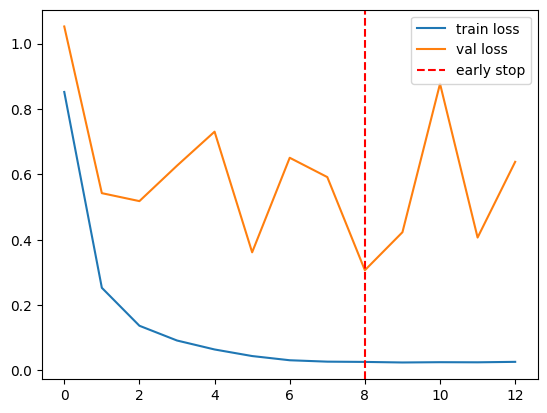

In [ ]:
# Plot training loss và validation loss, early stop ở epoch nào
plt.plot(trainer1.history_average_train_loss, label='train loss')
plt.plot(trainer1.history_average_val_loss, label='val loss')
plt.axvline(trainer1.early_stop_epoch-3, color='r', linestyle='--', label='early stop')
plt.legend()
plt.show()

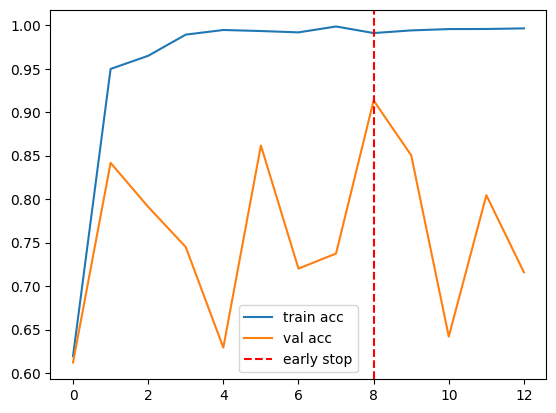

In [ ]:
# Plot cho accuracy
plt.plot(trainer1.history_average_train_acc, label='train acc')
plt.plot(trainer1.history_average_val_acc, label='val acc')
plt.axvline(trainer1.early_stop_epoch-3, color='r', linestyle='--', label='early stop')
plt.legend()
plt.show()